In [1]:
#Srinivasa Marappa - Lending Club Case Study - June 24 2019
#Risk1: Not lending to an applicant who is likely to repay loan - Loss of business to company - Revenue and profit
#Risk2: Lending to an applicant who is not likely to repay loan - Financial loss for the company (Credit Loss)
# Derive insights (consumer attributes, loan attributes) from past loan applicants who have defaulted to identify pattern 
# if a person is likely to default - Identification of such applicants using EDA is the aim of this case study.
# Driving factors / Driver variables for loan default 
# Actions (Risk Assessment, )
# 1. Denying the loan
# 2. Reduce the amount of loan 
# 3. Lend to risky applicants at higher interest rate

In [2]:
# Import required Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set display format 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#sns.set_style("whitegrid")

In [3]:
#Load provided data to data frame
df_LoanRecords = pd.read_csv("loan.csv", low_memory=False, encoding="ANSI")

In [4]:
#remove blank spaces 
print("Analyze columns for retention **********start*************")
print("Columns Stage 1: Provided Data Set ",len(df_LoanRecords.columns))
df_LoanRecords.replace('^\s+', '', regex=True, inplace=True) #front
df_LoanRecords.replace('\s+$', '', regex=True, inplace=True) #end

#Drop all columns which have only one unique value
df_LoanRecords = df_LoanRecords[[c for c in list(df_LoanRecords) if len(df_LoanRecords[c].unique()) > 1]]

print("Columns Stage 2: unique values dropped ",len(df_LoanRecords.columns))

#Analyze columns which have two unique values decide to retain term (36, 60) and 
#drop off collections_12_mths_ex_med (0, NA), chargeoff_within_12_mths (0, NA), tax_liens (0, NA)
nonvalueaddcolumns = []
for col in df_LoanRecords.columns:
    if (len(df_LoanRecords[col].unique()) == 2 and col != "term"):
        nonvalueaddcolumns.append(col)

df_LoanRecords.drop(columns=nonvalueaddcolumns,inplace=True)
print("Columns Stage 3: non value add columns (having two unique values) dropped ",len(df_LoanRecords.columns))

#drop columns having less than 10% data
df_LoanRecords.dropna(thresh=len(df_LoanRecords)*0.9,axis='columns',inplace=True)
print("Columns Stage 4: less than 10% data dropped ",len(df_LoanRecords.columns))

#drop columns through observation which do not add value to analysis
ignoredcolumns = [
    'url'
]
df_LoanRecords.drop(columns=ignoredcolumns,inplace=True)
print("Columns Stage 5: non value add columns dropped through data observation ",len(df_LoanRecords.columns))


print("Analyze columns for retention **********end*************")

Analyze columns for retention **********start*************
Columns Stage 1: Provided Data Set  111
Columns Stage 2: unique values dropped  51
Columns Stage 3: non value add columns (having two unique values) dropped  48
Columns Stage 4: less than 10% data dropped  44
Columns Stage 5: non value add columns dropped through data observation  43
Analyze columns for retention **********end*************


In [5]:
print("column data cleanup           **********start*************")
#further cleaning of data in columns starts

#Extract first two characters of term
df_LoanRecords['term'] = df_LoanRecords['term'].str[0:2]
df_LoanRecords['int_rate'].replace(r'([.]*)\%', r'\1', regex=True,inplace = True)
df_LoanRecords['revol_util'].replace(r'([.]*)\%', r'\1', regex=True,inplace = True)
#if emp_length is not available - np.nan, it is considered to be zero (0)
df_LoanRecords['emp_length'].replace([ np.nan,"< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"], [0,0,1,2,3,4,5,6,7,8,9,10],inplace = True)
#in absence of last_credit_pull_d, it is set to issue_d as credit report should have been pulled before issuing loan
df_LoanRecords['last_credit_pull_d'] = np.where(pd.isnull(df_LoanRecords['last_credit_pull_d']), df_LoanRecords['issue_d'], df_LoanRecords['last_credit_pull_d'])
#in absence of revol_util, it is set to installment amount * 12 months as a percentage of income //thought process...
df_LoanRecords['revol_util'] = np.where(pd.isnull(df_LoanRecords['revol_util']), (df_LoanRecords['installment']*12*100)/df_LoanRecords['annual_inc'], df_LoanRecords['revol_util'])
#set to numeric marker value of -1 (can be 0 - need to agree as a team)
df_LoanRecords['pub_rec_bankruptcies'] = np.where(pd.isnull(df_LoanRecords['pub_rec_bankruptcies']), -1, df_LoanRecords['pub_rec_bankruptcies'])


df_LoanRecords['issue_d'] = pd.to_datetime(df_LoanRecords['issue_d'].str[4:6]  + df_LoanRecords['issue_d'].str[0:3], format='%y%b')
df_LoanRecords['last_pymnt_d'] = pd.to_datetime(df_LoanRecords['last_pymnt_d'].str[4:6]  + df_LoanRecords['last_pymnt_d'].str[0:3], format='%y%b')
df_LoanRecords['last_credit_pull_d'] = pd.to_datetime(df_LoanRecords['last_credit_pull_d'].str[4:6]  + df_LoanRecords['last_credit_pull_d'].str[0:3], format='%y%b')
df_LoanRecords['earliest_cr_line'] = pd.to_datetime(df_LoanRecords['earliest_cr_line'].str[4:6]  + df_LoanRecords['earliest_cr_line'].str[0:3], format='%y%b')


#Fill NA for blanks
df_LoanRecords.fillna({'emp_title':'NA', 'title':'NA'}, inplace=True)
df_LoanRecords['emp_title'] = df_LoanRecords['emp_title'].str.title()
df_LoanRecords['emp_title'].replace(r'([Uu])[nited]*[. ]*([Ss])[tates]*[. ]*Army', r'\1\2 Army', regex=True,inplace = True)

df_LoanRecords = df_LoanRecords.astype(
    { "term": np.uint, "emp_length": np.uint, 
      "int_rate": np.float64, "revol_util": np.float64 }
)
#work in progress
print("column data cleanup           **********end*************")


column data cleanup           **********start*************
column data cleanup           **********end*************


In [6]:
df_LoanRecords.to_excel("df_LoanRecords.xlsx", sheet_name='df_LoanRecords')
#Clean up columns ends

In [7]:
#print(df_LoanRecords.describe())
#print(df_LoanRecords.info())
#print(df_LoanRecords['earliest_cr_line'].dt.year)

def months(d1, d2):
    return d1.dt.month - d2.dt.month -1 + 12*(d1.dt.year - d2.dt.year)


#print(months(df_LoanRecords.last_pymnt_d.dt.to_period('M'), df_LoanRecords.issue_d.dt.to_period('M') ) )
print(months(df_LoanRecords.last_pymnt_d.dt.to_period('M'), df_LoanRecords.issue_d.dt.to_period('M') ) )

#from datetime import datetime
#from dateutil import relativedelta
#r = relativedelta.relativedelta(df_LoanRecords.last_pymnt_d, df_LoanRecords.issue_d)
#r.months


0           36
1           15
2           29
3           36
4           52
5           36
6           52
7           36
8            3
9           10
10          17
11          20
12           6
13          36
14          21
15          36
16          36
17          16
18          37
19           6
20          43
21          20
22          36
23          21
24           9
25           8
26      -24158
27          11
28          15
29          35
         ...  
39687       34
39688       29
39689       35
39690        8
39691       35
39692       35
39693       19
39694        5
39695       35
39696       34
39697       35
39698       35
39699       32
39700       35
39701       35
39702       35
39703       35
39704       35
39705       35
39706       35
39707       35
39708       35
39709       35
39710       35
39711       35
39712       35
39713       35
39714        8
39715        5
39716       35
Length: 39717, dtype: int64


In [8]:
missing_count = (df_LoanRecords.isnull().sum() / len(df_LoanRecords)) * 100
# Filter to find the missing count > 0
missing_count = missing_count[missing_count > 0]
print(missing_count.sort_values())

last_pymnt_d   0.179
dtype: float64


In [9]:
#Add additional columns for further analysis starts

#Add additional columns for further analysis ends

In [10]:
# Finding numerical features
numeric_data = df_LoanRecords.select_dtypes(include = [np.number])
# Finding categorical features
categorical_data = df_LoanRecords.select_dtypes(exclude = [np.number])
#Let's print how many numerical and categorical features do we have
print('There are {0} numerical and {1} categorical features in the data set'.\
     format(numeric_data.shape[1], categorical_data.shape[1]))
print(numeric_data.columns)
print(categorical_data.columns)

There are 29 numerical and 14 categorical features in the data set
Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'pub_rec_bankruptcies'],
      dtype='object')
Index(['grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d',
       'last_credit_pull_d'],
      dtype='object')


*************insights and observations starts************


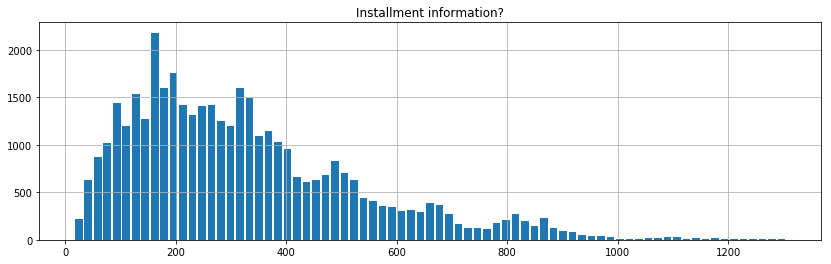

*************insights and observations ends************


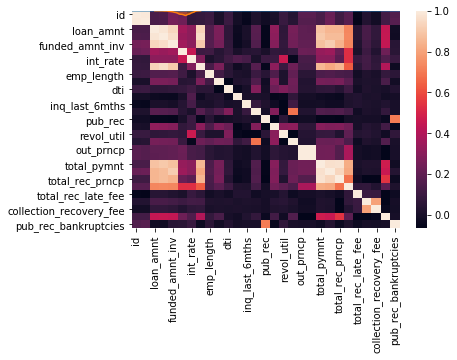

In [11]:
#Insights and Observations from Analysis starts
print("*************insights and observations starts************")

%matplotlib inline

df_LoanRecords.installment.hist(bins=75, rwidth=.8, figsize=(14,4))
plt.title('Installment information?')
plt.show()
sns.distplot(df_LoanRecords['installment'])
# Most machine learning algorithm works well with data which are normally distributed
target = np.log(df_LoanRecords['installment'])
sns.distplot(target)

# Correlation plot of the features in numeric_data
corr = numeric_data.corr()
# Plot the correlation matrix
sns.heatmap(corr,robust=True)

print("*************insights and observations ends************")
#Insights and Observations from Analysis ends

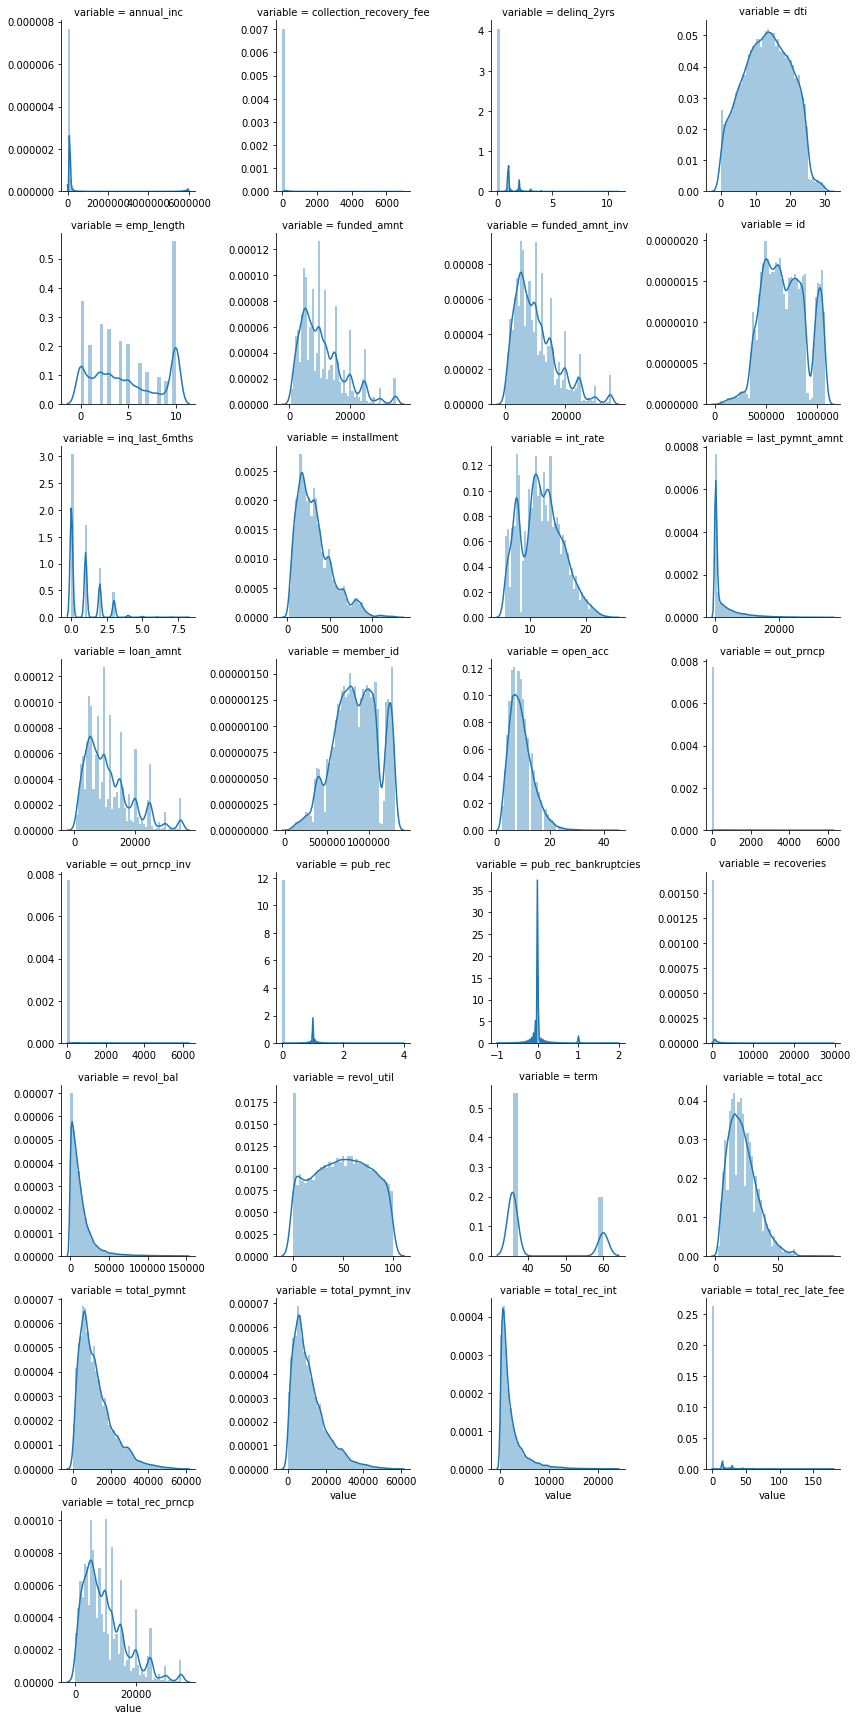

In [12]:
f = pd.melt(df_LoanRecords, value_vars=sorted(numeric_data))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

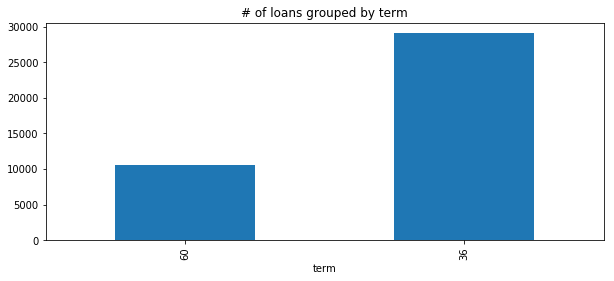

In [13]:
df_LoanRecords.groupby('term').id.count().\
    sort_values().\
    plot(kind='bar', figsize=(10,4))
plt.title('# of loans grouped by term')
plt.show()